# Common grid bias-adjustment quality control

Quality control the bias-adjusted data!

In [1]:
# parameters cell
working_dir = "/import/beegfs/CMIP6/kmredilla"
sim_dir = "/import/beegfs/CMIP6/kmredilla/cmip6_regridding/regrid"
ref_dir = "/import/beegfs/CMIP6/arctic-cmip6/era5/daily_regrid"

In [2]:
from datetime import datetime
from itertools import product
from pathlib import Path
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from dask.distributed import Client
from config import output_dir_name, ref_tmp_fn
from bias_adjust import generate_cmip6_fp
from slurm import get_directories
from luts import sim_ref_var_lu


working_dir = Path(working_dir)
sim_dir = Path(sim_dir)
ref_dir = Path(ref_dir)

output_dir, adj_dir = get_directories(working_dir, output_dir_name)

## Verify long term average day-of-year summaries

Compare the averaged day-of-year values between reference data, unadjusted model data, and adjusted model data.

We will do this visually by just plotting time series for a few locations. 

We can compare this numerically for the whole datasets by using some distance metric like RMSE on the day-of-year means. We would assume the RMSE between adjusted-modeled and ERA5 reference is less than the biased-modeled and ERA5 reference.

We will just check both of these things at the same time for efficient data access.

In [3]:
client = Client(n_workers=4, memory_limit="4GB")

distributed.diskutils - INFO - Found stale lock file and directory '/import/home/kmredilla/repos/cmip6-utils/bias_adjust/dask-worker-space/worker-fwejdqe2', purging
distributed.diskutils - INFO - Found stale lock file and directory '/import/home/kmredilla/repos/cmip6-utils/bias_adjust/dask-worker-space/worker-faqr9pry', purging
distributed.diskutils - INFO - Found stale lock file and directory '/import/home/kmredilla/repos/cmip6-utils/bias_adjust/dask-worker-space/worker-g2c_bkov', purging
distributed.diskutils - INFO - Found stale lock file and directory '/import/home/kmredilla/repos/cmip6-utils/bias_adjust/dask-worker-space/worker-y9tsiqex', purging


In [4]:
# global variables for simplicity
sim_ref_start_year = 2015
sim_ref_end_year = 2022
# sim_dir, ref_dir, adj_dir are set initially


def get_fps(model, scenario, var_id):
    sim_ref_years = list(range(sim_ref_start_year, sim_ref_end_year + 1))
    ref_var_id = sim_ref_var_lu[var_id]
    ref_fps = [
        ref_dir.joinpath(var_id, ref_tmp_fn.format(ref_var_id=ref_var_id, year=year))
        for year in sim_ref_years
    ]

    sim_ref_years = list(range(sim_ref_start_year, sim_ref_end_year + 1))
    sim_ref_fps = [
        generate_cmip6_fp(sim_dir, model, scenario, var_id, year)
        for year in sim_ref_years
    ]

    adj_fps = list(adj_dir.joinpath(model, scenario, "day", var_id).glob("*.nc"))

    return ref_fps, sim_ref_fps, adj_fps


def plot_single_pixel_mean_doy(
    model,
    scenario,
    var_id,
):

    ref_fps, sim_ref_fps, adj_fps = get_fps(model, scenario, var_id)

    adj_ds = xr.open_mfdataset(adj_fps)
    ref_ds = xr.open_mfdataset(ref_fps)
    sim_ref_ds = xr.open_mfdataset(sim_ref_fps)

    # pick a random pixel within the domain
    lat = np.random.choice(ref_ds.lat.values)
    lon = np.random.choice(ref_ds.lon.values)
    sel_di = dict(lat=lat, lon=lon)

    ref_var_id = sim_ref_var_lu[var_id]
    ref_ds[ref_var_id].sel(sel_di).groupby("time.dayofyear").mean().plot(
        label="Reference"
    )
    sim_ref_ds[var_id].sel(sel_di).groupby("time.dayofyear").mean().plot(
        label="Model - biased"
    )
    adj_ds[var_id].sel(time=slice(str(sim_ref_start_year), str(sim_ref_end_year))).sel(
        sel_di
    ).groupby("time.dayofyear").mean().plot(label="Model - adjusted", linestyle="--")

    plt.legend()

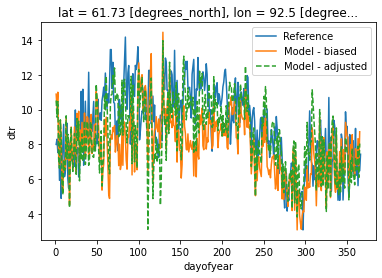

In [5]:
plot_single_pixel_mean_doy("GFDL-ESM4", "ssp585", "dtr")